In [12]:
%matplotlib inline
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import leastsq


EPOINT = 0 # need to fix this
np.seterr(invalid='ignore')
plt.rcParams.update({'font.size': 20})
cmap = plt.cm.Spectral # color scheme -- visible color spectrum, starting with red as the earliest
names=("t_start", "t_stop", "t_peak", "amplitude", "FWHM", "duration", "t_peak_aflare1", 
       "t_FWHM_aflare1", "amplitude_aflare1", "flare_chisq", "KS_d_model", "KS_p_model", 
       "KS_d_cont", "KS_p_cont", "Equiv_Dur", "ED68i", "ED90i")

In [13]:
def getSize(file):
    temp = pd.read_table(file, names=['kic'])
    getsize = temp['kic'].values
    return getsize.size

def calcChiSq(data, fit, errList):
    chiSq = np.sum(((data - fit) / errList)**2.0)/np.size(data)
    return chiSq

def calcError(data, multiple):
    data = data*multiple
    errDn = (np.abs(data * (1.-1./(9. * data)-1./(3.*np.sqrt(data)))**3.-data))/multiple
    errUp = (np.sqrt(data + 0.75) + 1.0)/multiple
    return errUp, errDn


def calcBic(size, degree, chiSq):
    bic = chiSq + ((degree+1) * np.log(size))
    return bic
        
def fitDegreeK(xaxis, yaxis, errList, degree, size):
    if(degree == 0):
        parameters = [np.mean(yaxis)]
        covariance = np.array([[np.std(yaxis)**2,0],[0,0]])
    else:
        parameters, covariance = np.polyfit(xaxis, yaxis, degree, cov=True, full =False)

    fit = np.polyval(parameters, xaxis)
    chiSq = calcChiSq(yaxis, fit, errList)
    bic = calcBic(size, degree, chiSq)
    return bic, fit, parameters, covariance, chiSq

def updateArray(exportArray, targetIndex, KIC, degree, bestParameters, bestChiSquare, bestCov):
    exportArray[targetIndex, 0] = KIC
    exportArray[targetIndex,1] = degree
    exportArray[targetIndex, 2] = '{}'.format('%.4f'%bestChiSquare)
    length = len(bestParameters)
    for x in range(length):
        exportArray[targetIndex, (7-length+x)] = '{}'.format('%.4f'%bestParameters[x])
        exportArray[targetIndex, (11-length+x)] = '{}'.format('%.4f'%(np.sqrt(bestCov[x,x]))) #Make sure this is adding the error
    return exportArray

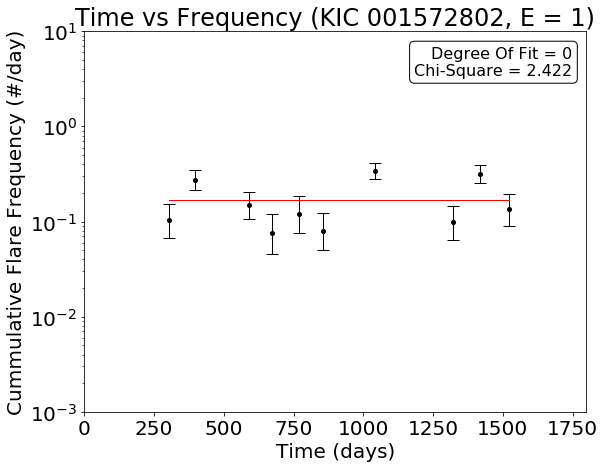

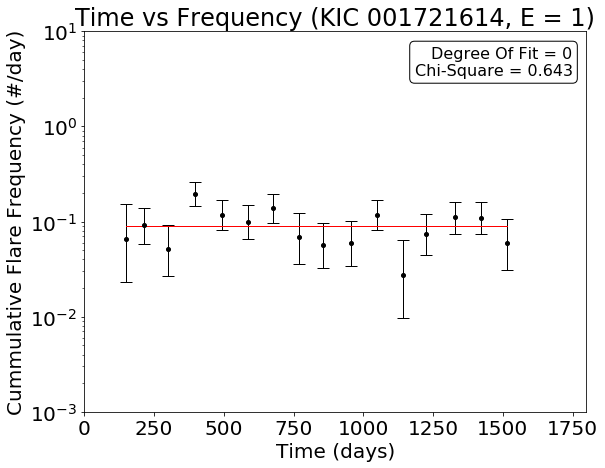

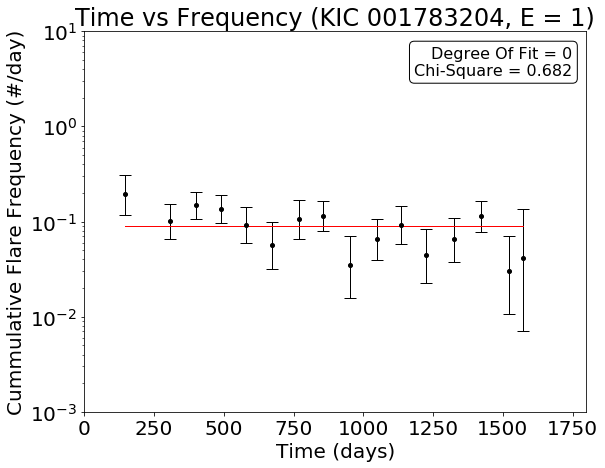

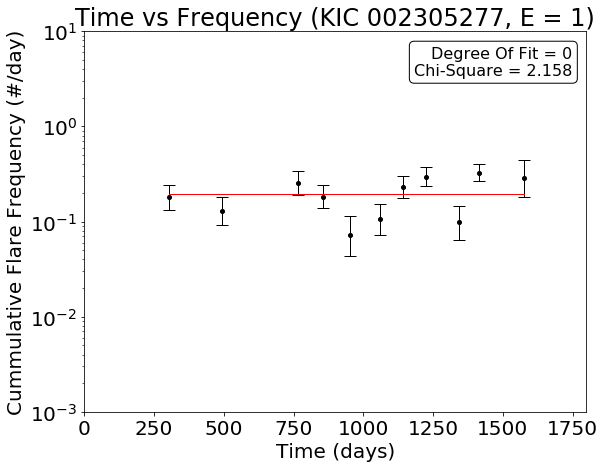

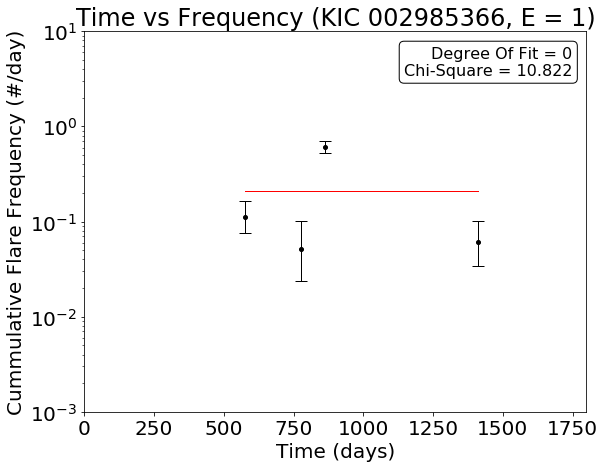

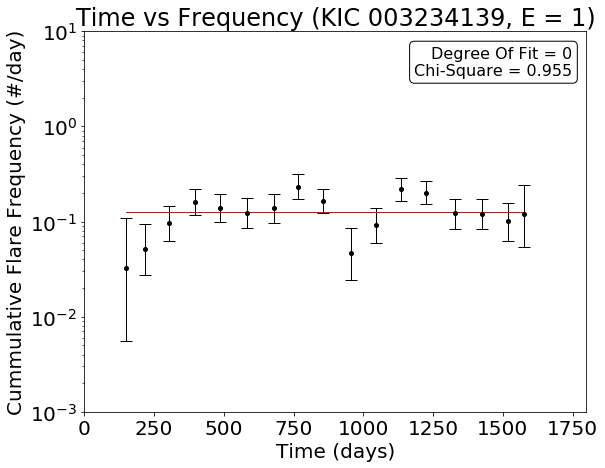

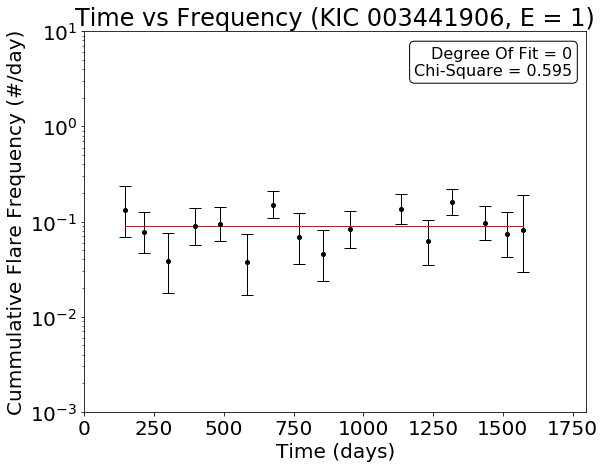

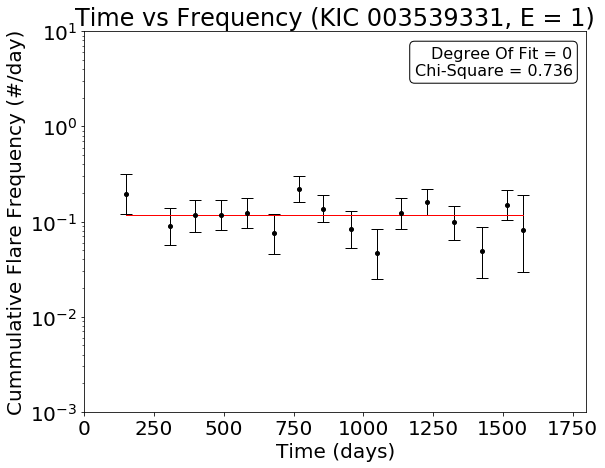

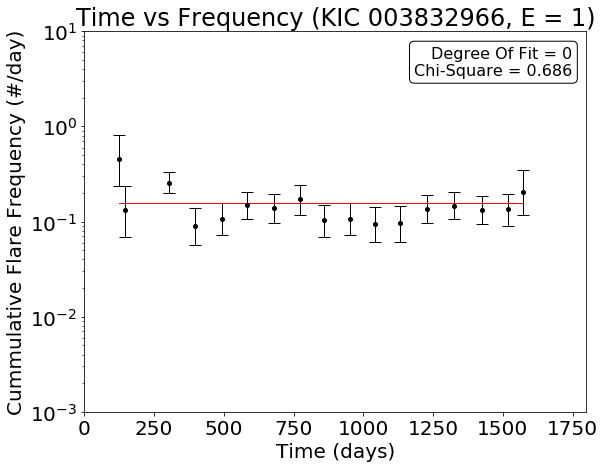

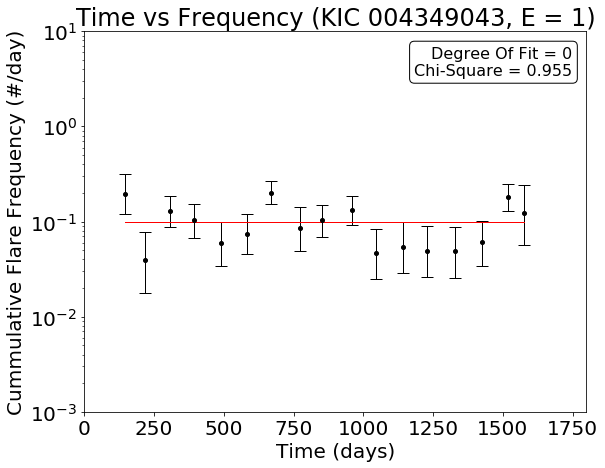

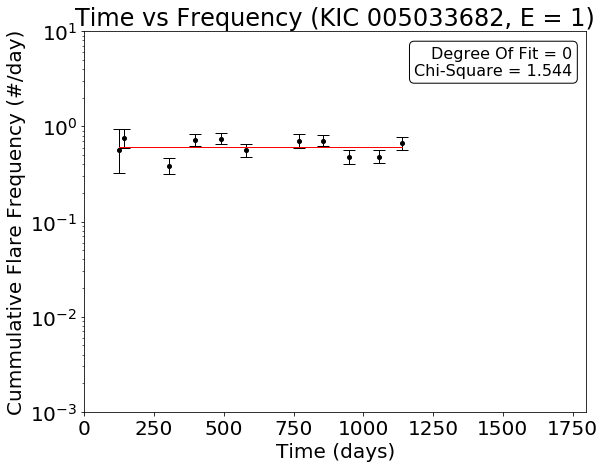

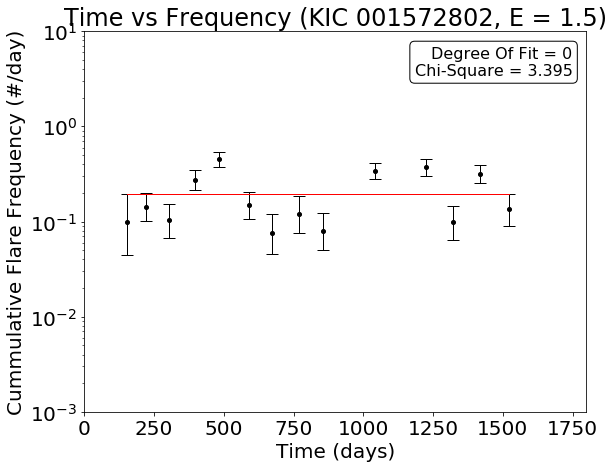

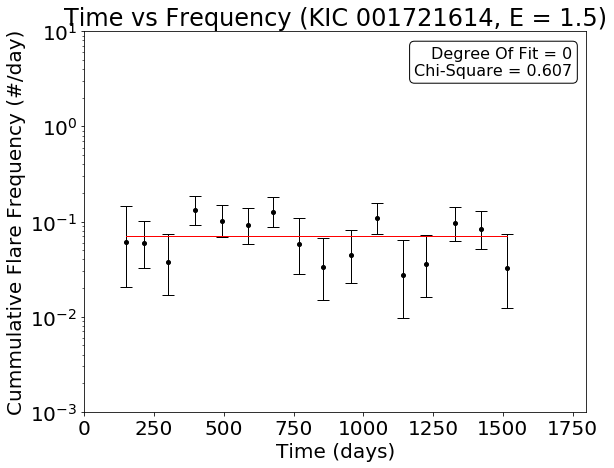

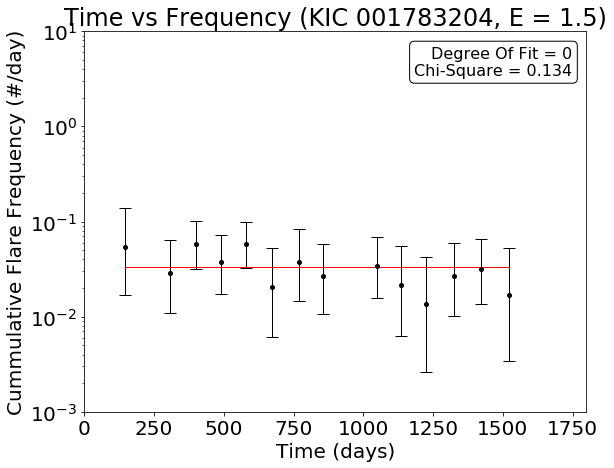

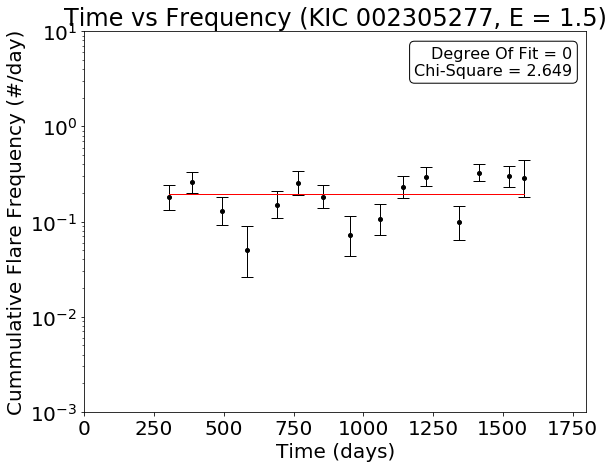

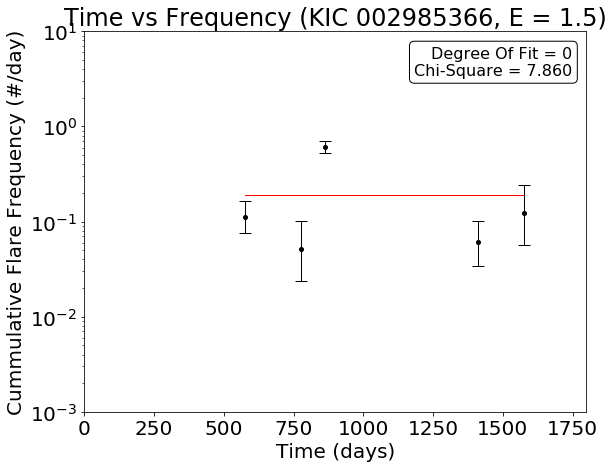

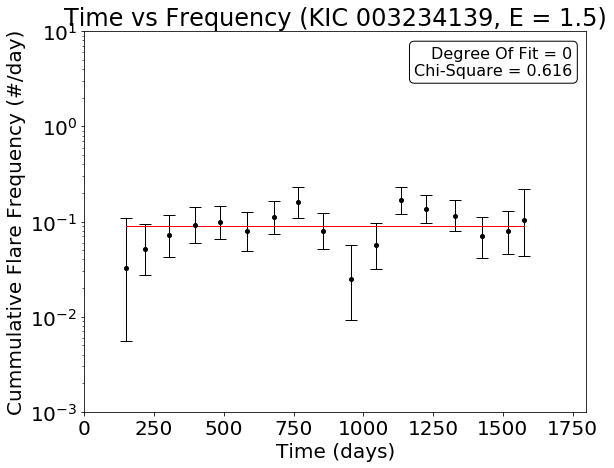

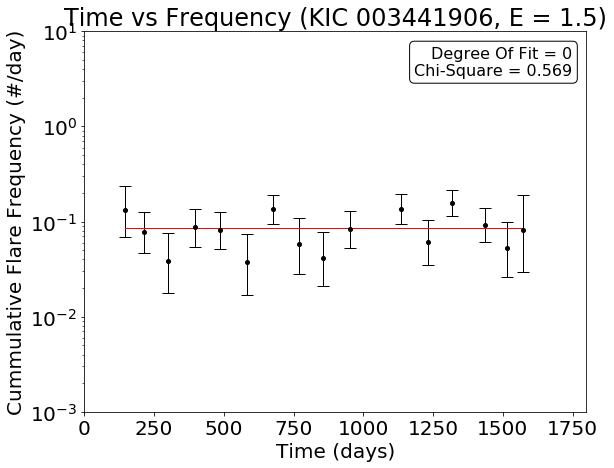

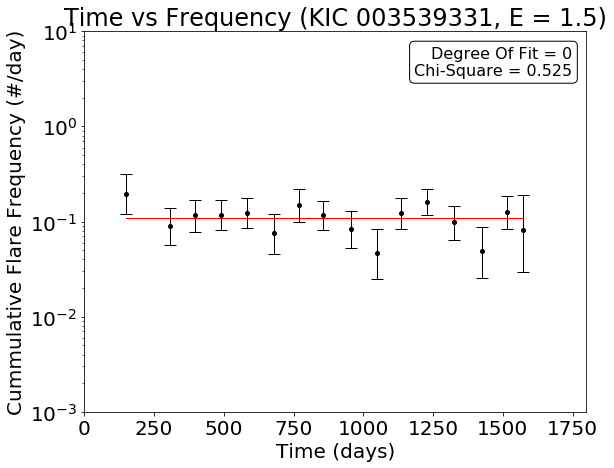

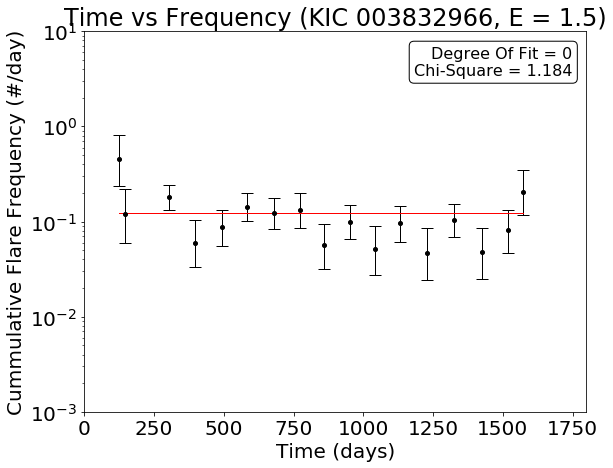

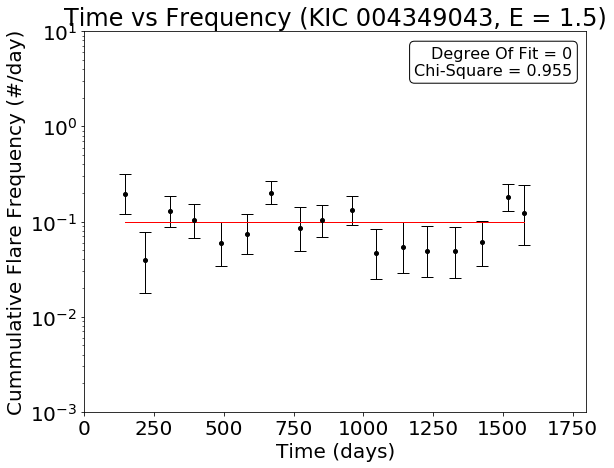

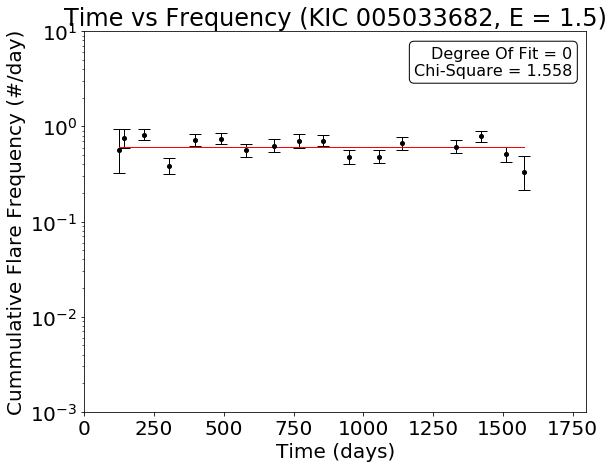

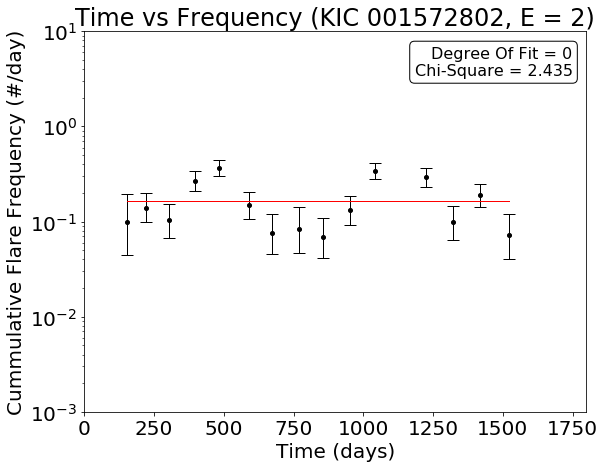

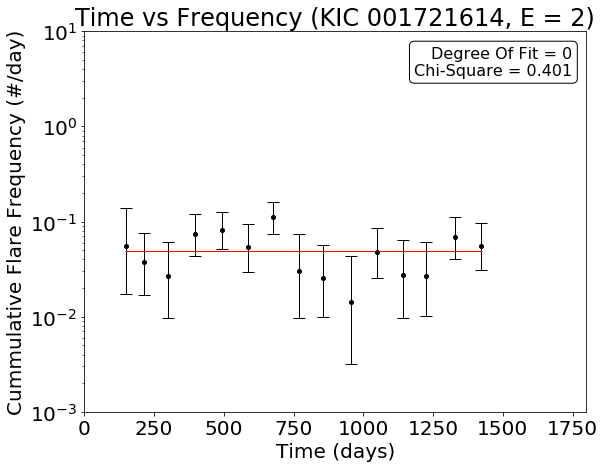

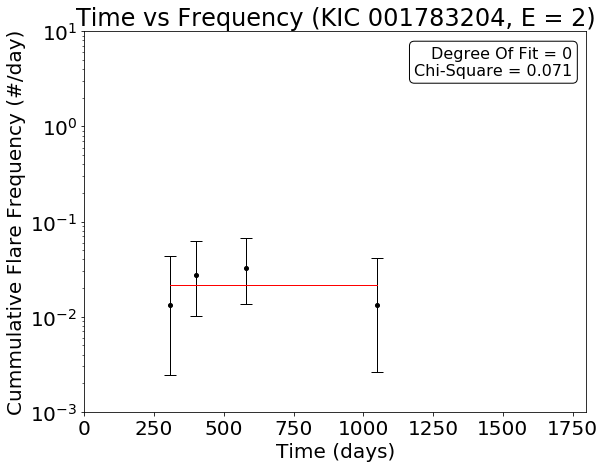

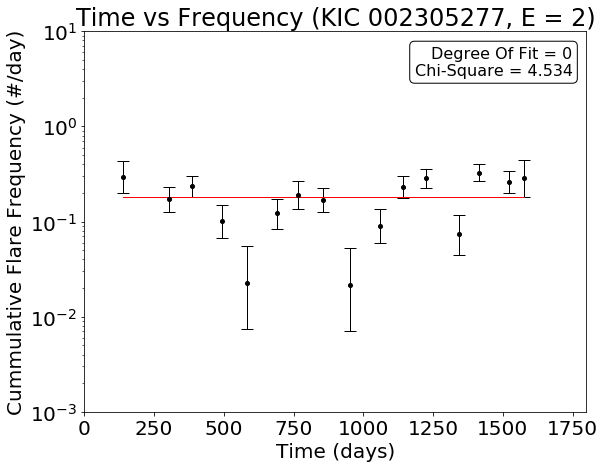

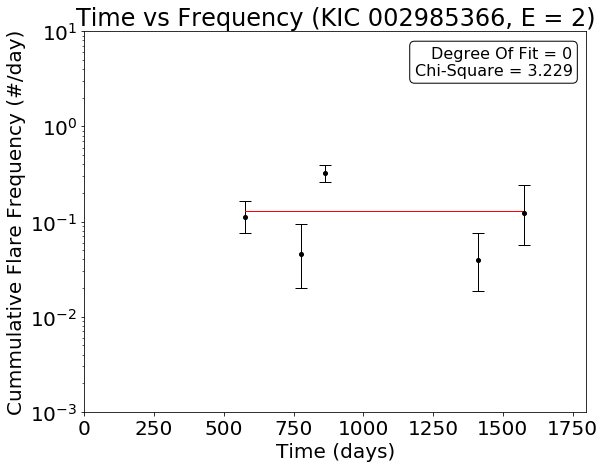

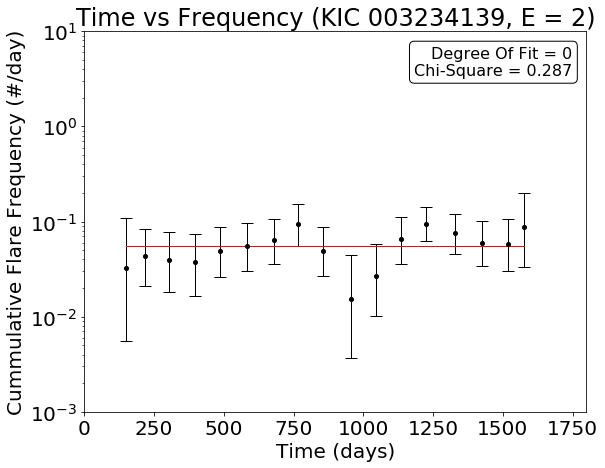

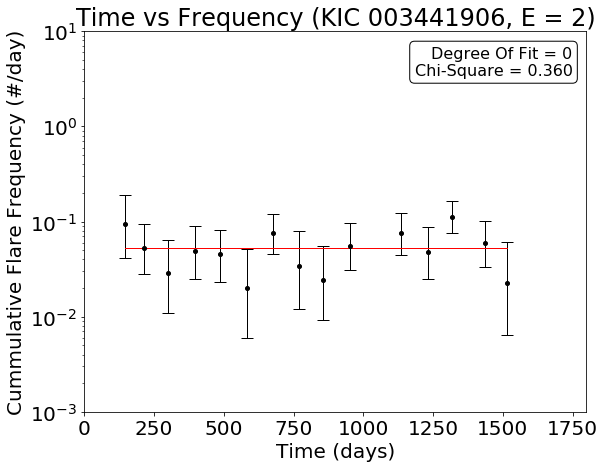

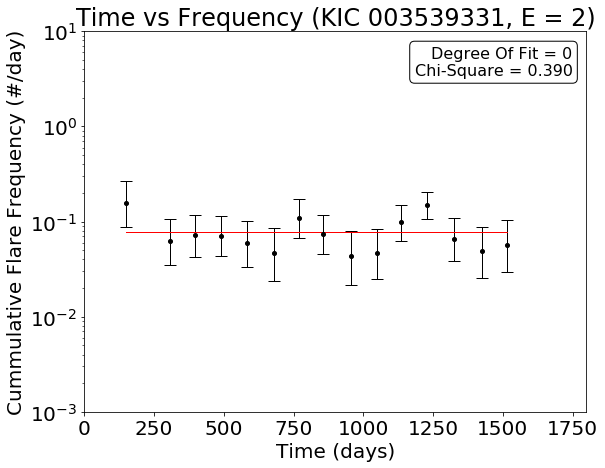

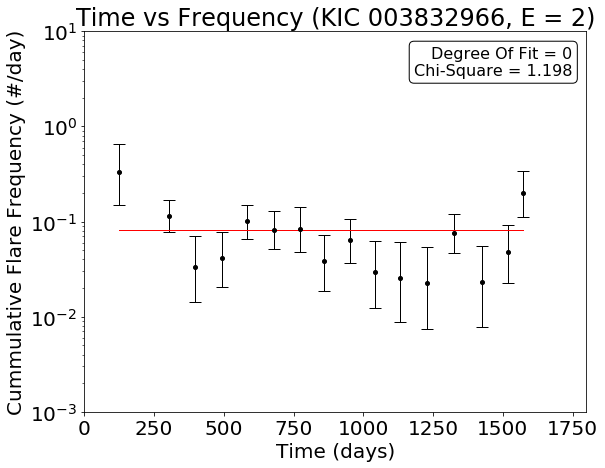

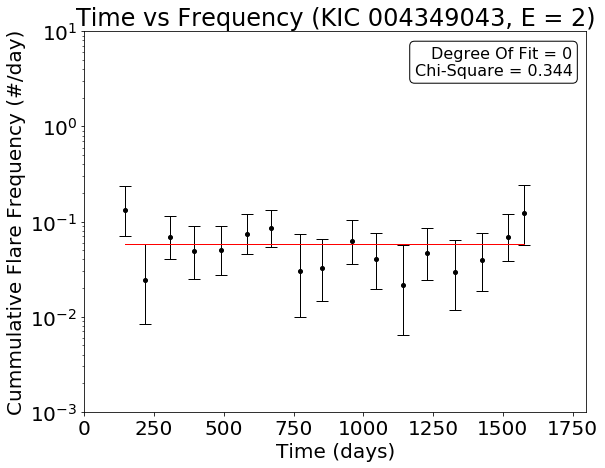

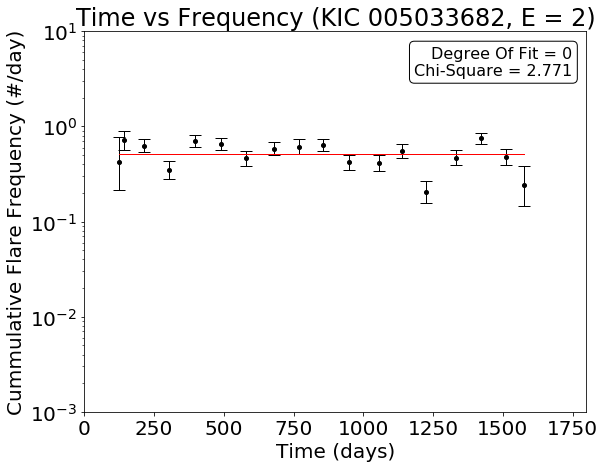

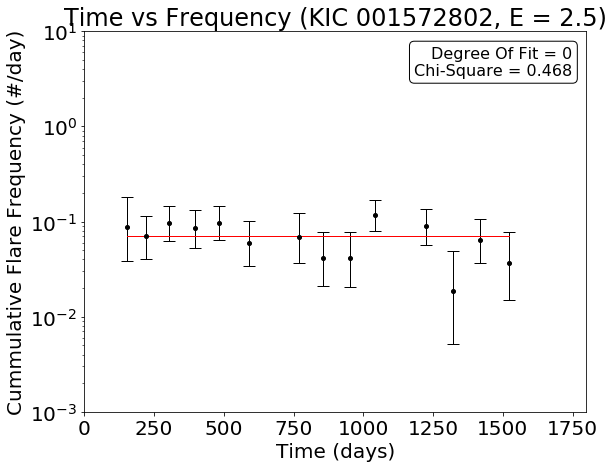

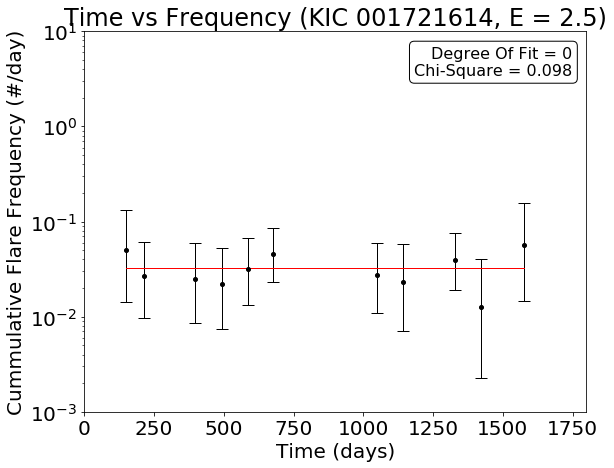

D:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
D:\Anaconda\lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


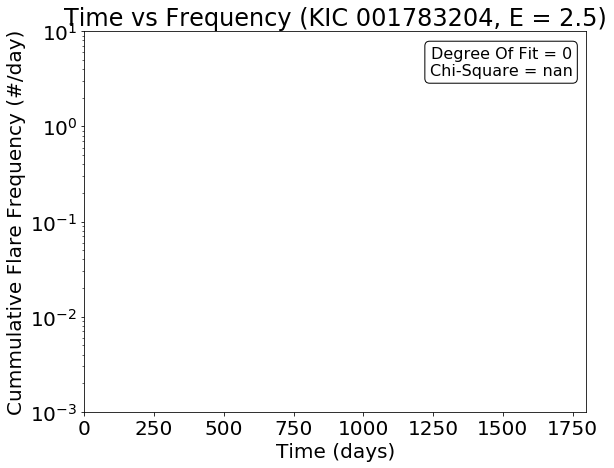

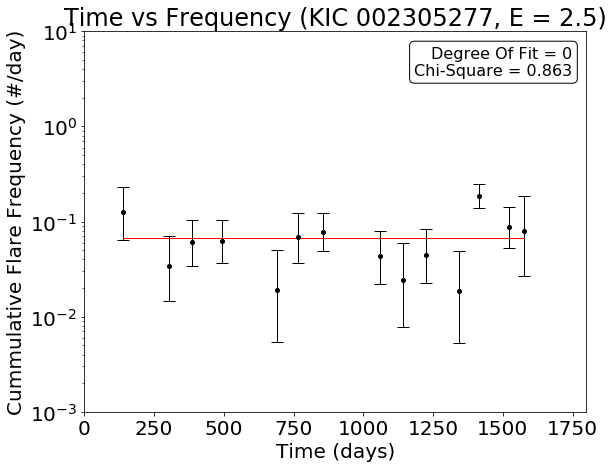

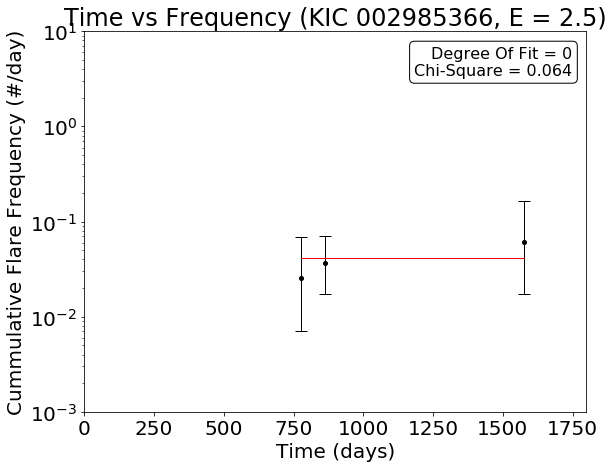

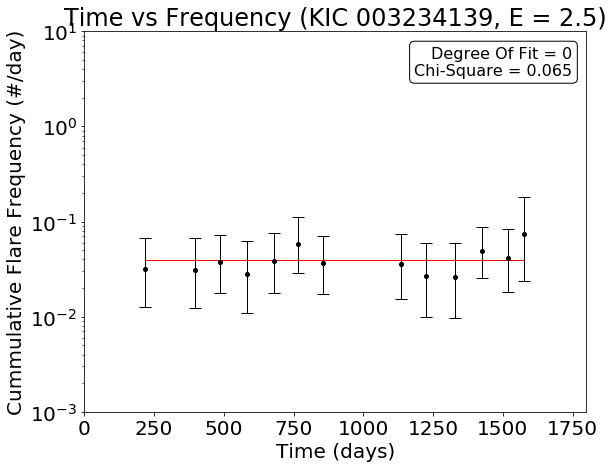

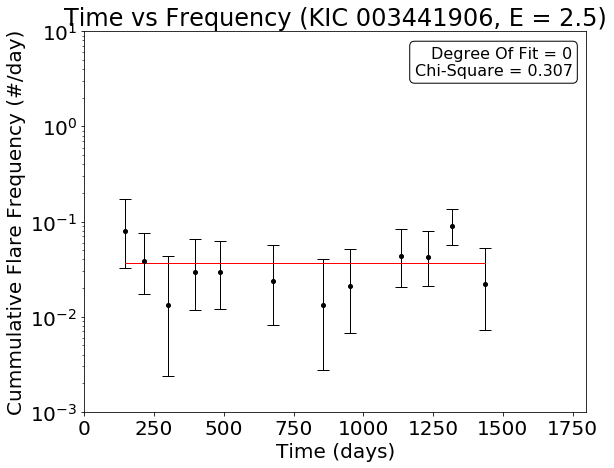

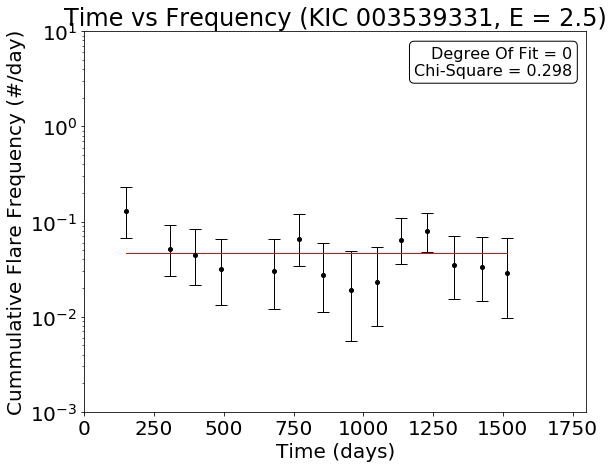

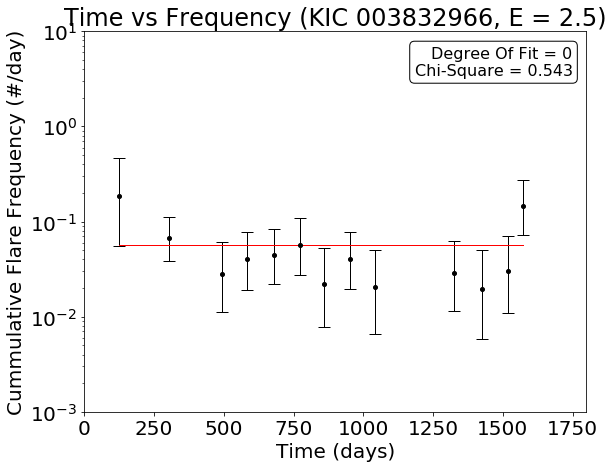

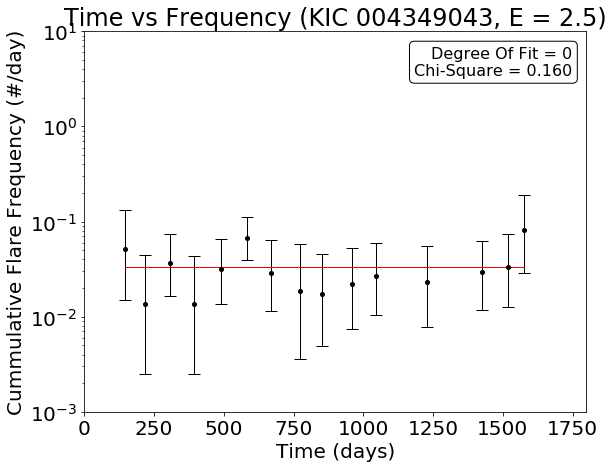

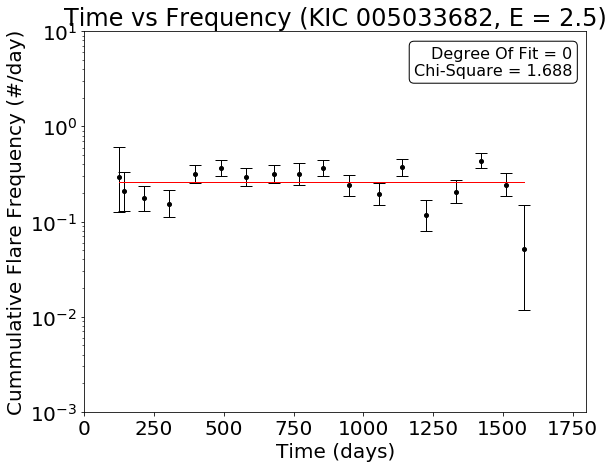

In [38]:
#Specify a fixed log-energy value. Plot the mean-time vs FFD_y values = plot time vs flare rate per day
targetCount = getSize('KICs/targets.txt') #getting the number of targets using the target file
energyConstantList = [1, 1.5, 2, 2.5]

for energyConstant in energyConstantList:
    
    targets = open('KICs/targets.txt', "r") # a file containing all the KICs we want to plot  
    fixedEnergy = energyConstant + EPOINT # the fixed energy value
    exportArray = np.zeros((targetCount + 2, 11), dtype='O')
    exportArray[0] = ["#This is a file containing the parameters and errors involved in the best fit of a KIC's time vs frequency data",'','','','','','','','','',''] 
    exportArray[1] = ["#KIC", '#degree', '#chiSquare', '#X^3', '#X^2', '#X^1', '#X^0', '#Error3', '#Error2', '#Error1', '#Error0']
    targetIndex = 2

    for line in targets: #going through each KIC

        KIC = line.rstrip('\n') #stripping the return off each line
        files = glob('KICS/'+KIC+"/*.flare") #Glob all of the files in the directory - get all flares for a star

        plt.figure(figsize=(9,7))
        plt.title("Time vs Frequency (KIC "+KIC+', E = '+str(fixedEnergy)+')')
        plt.ylabel("Cummulative Flare Frequency (#/day)")
        plt.xlabel("Time (days)")
        plt.yscale('log')
        plt.ylim([0.001,10])
        plt.xlim([0,1800])
        xaxis = np.array([])
        yaxis = np.array([])
        errList = np.array([])

        for x in range(len(files)):

            toteDuration = pd.read_table(files[x], skiprows=5, nrows=1, header=None, delim_whitespace=True, usecols=(7,)).iloc[0].values[0] #getting the total duration of each file
            df = pd.read_table(files[x], comment="#", delimiter=",", names=names)
            energy = df['Equiv_Dur'] #This is the energy column of the flare data
            sort = np.argsort(energy) #get indices that would sort the energy array
            ffdXEnergy = np.log10(energy[sort][::-1]) + EPOINT #log the reverse of sorted energy
            ffdYFrequency = (np.arange(1, len(ffdXEnergy)+1, 1))/toteDuration #get evenly spaced intervals, divide by totedur to get flares/day

            if(np.amax(ffdXEnergy) >= fixedEnergy >= np.amin(ffdXEnergy)): #checking that the energy constant isn't out of bound,otherwise, interpolate doesn't work

                ok68 = ffdXEnergy >= np.log10(np.median(df['ED68i'])) + EPOINT #use ED68i to get indices of useful data, ignore the junk
                meanStart = np.sum(df['t_start'])/len(df['t_start']) #finding the mean time for a file

                if any(ok68): #checking if ok68 contains at least one 'true'

                    ffdYAtEnergy = np.interp(fixedEnergy, ffdXEnergy[ok68][::-1], ffdYFrequency[ok68][::-1])#interpolating the ffd_y
                    xaxis = np.append(xaxis, meanStart) #making lists so we can fit a line later
                    yaxis = np.append(yaxis, ffdYAtEnergy)

                    errUp, errDn = calcError(ffdYAtEnergy, toteDuration)#dealing w/ error
                    errList = np.append(errList, errUp) #collecting errors, to be used in chi-square calc
                    plt.errorbar(meanStart, ffdYAtEnergy, yerr = [[errDn], [errUp]], fmt='o', color= 'black',markersize=4, elinewidth=1,capsize=6)#plotting error

        size = np.size(xaxis)
        bestFitDegree = 0
        bic1, bestFit, bestParameters, bestCovariance, bestChiSquare = fitDegreeK(xaxis, yaxis, errList, bestFitDegree, size)
        degree = 1
        #print(KIC)
        #print(size)
        #print("degree, chisquare, bic = {}, {}, {}".format(0, '%.4f'%bestChiSquare, '%.4f'%bic1,))

        while(degree<4):
            
            try:
                bic2, fit, parameters, covariance, chiSquare = fitDegreeK(xaxis, yaxis, errList, degree, size)
                #print("degree, chisquare, bic = {}, {}, {}".format(0, '%.4f'%chiSquare, '%.4f'%bic2,))
            except:
                break
            
            if ((bic1 - bic2) >=2):  #DOUBLE CEHCK THIS
                bic1, bestFit, bestParameters, bestCovariance, bestChiSquare = bic2, fit, parameters, covariance, chiSquare
                bestFitDegree = degree
                degree+=1
            else:
                break

        #print()        
        exportArray = updateArray(exportArray, targetIndex, KIC, bestFitDegree, bestParameters, bestChiSquare, bestCovariance)
        plt.plot(xaxis, bestFit, 'red', lw=1)
        plt.annotate('Degree Of Fit = {}\nChi-Square = {}'.format(bestFitDegree, '%.3f'%(bestChiSquare)), xy=(1750, 7),size=16, ha='right', va='top',bbox=dict(boxstyle='round', fc='w'))
        plt.legend()
        targetIndex += 1
        plt.savefig('time_vs_ffdy_plot/'+KIC+'_vs_time_E='+str(fixedEnergy)+'.png')
        plt.show()
    
    np.savetxt('fit_data/fit_data_for_E='+str(fixedEnergy)+'.txt', exportArray, fmt = '% 10s', delimiter=' ', newline='\n', header='', footer='', comments='# ')
    targets.close()
    plt.close()

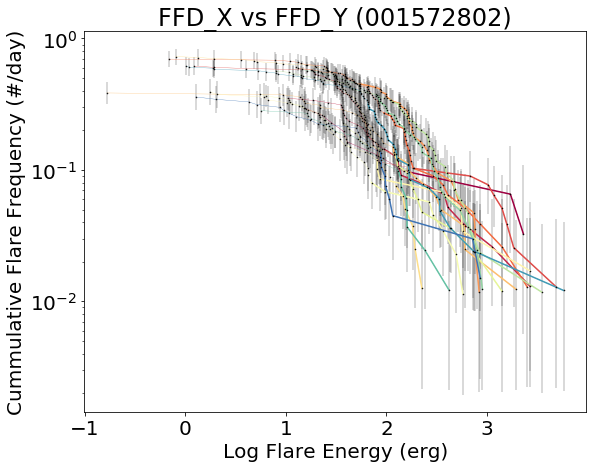

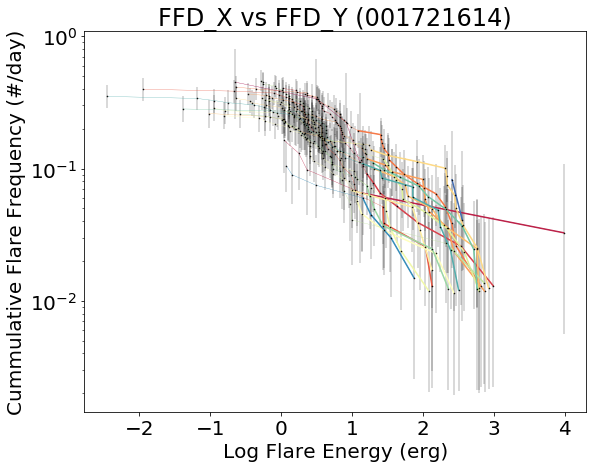

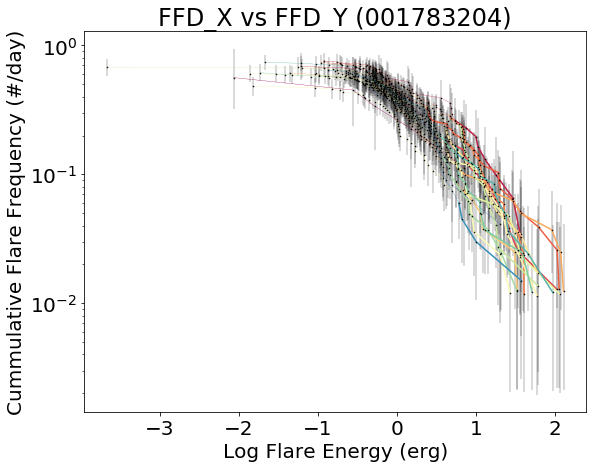

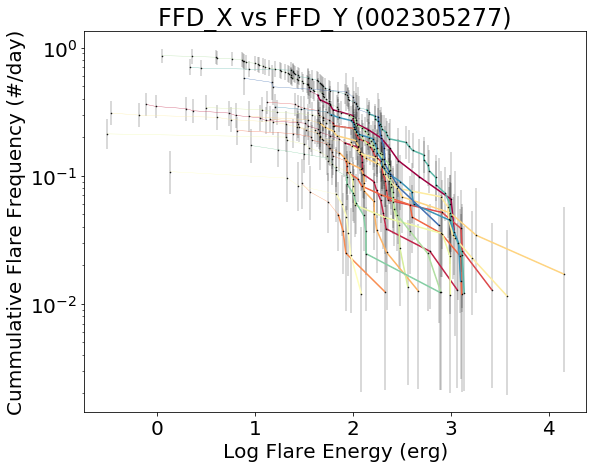

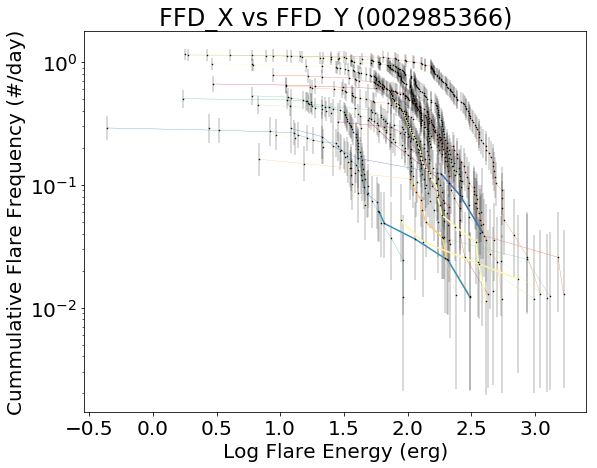

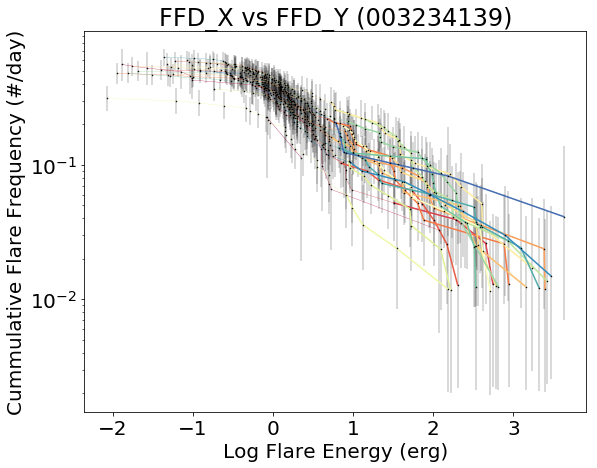

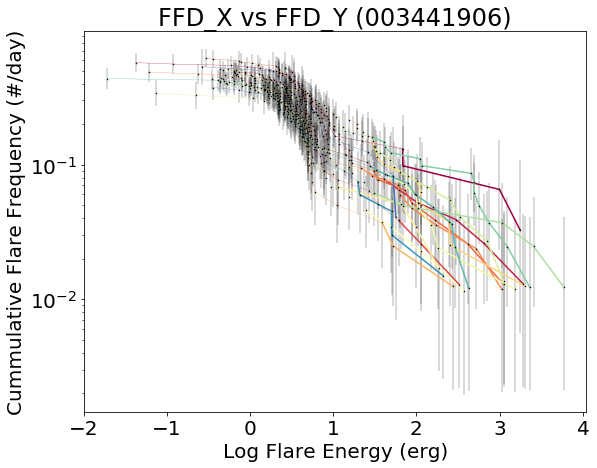

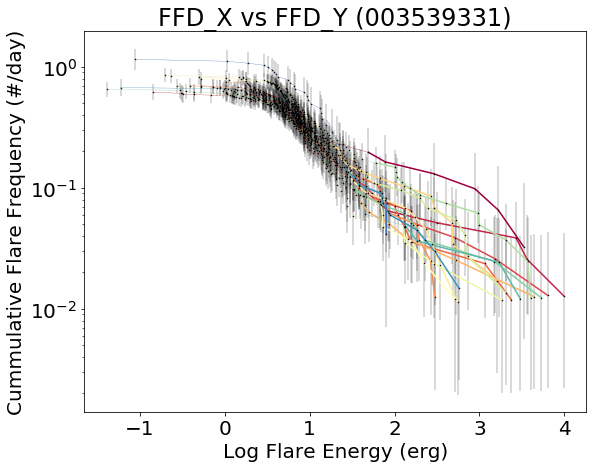

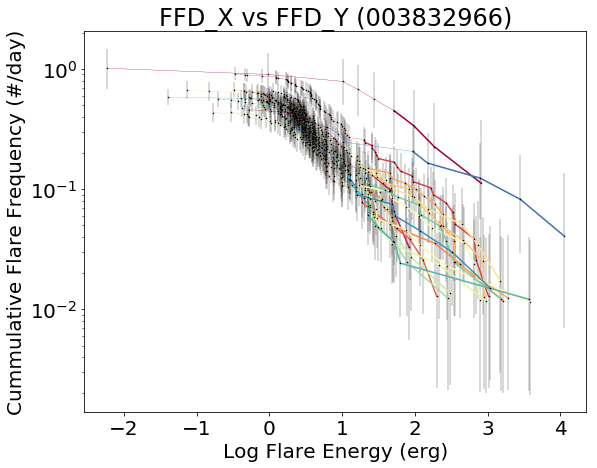

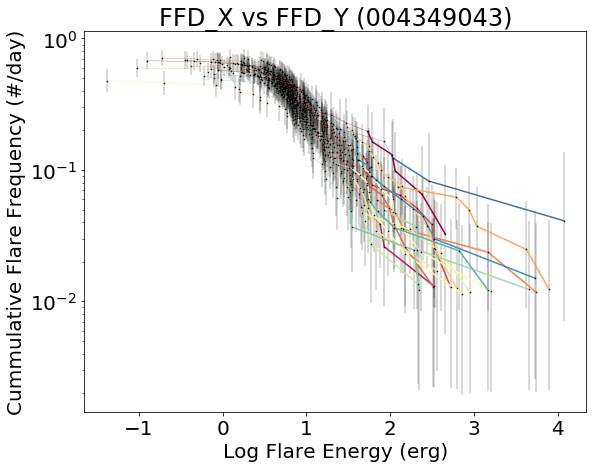

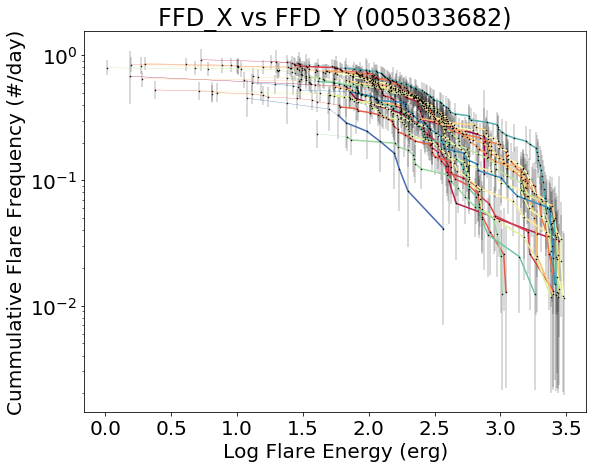

In [26]:
### plotting a reverse cummulative sum for a single KIC# number, hoping for a smooth change in frequency over time
#plotting all of the data, with data below the ED68i cutoff being the thinner lines

targets = open("KICs/targets.txt", "r") # a file containing all the KICs we want to plot

for line in targets: #going through each KIC
    
    KIC = line.rstrip('\n') #stripping the return off each line
    files = glob('KICs/'+KIC+"/*.flare") #Glob all of the files in the directory - get all flares for a star
    
    plt.figure(figsize=(9,7))
    plt.title("FFD_X vs FFD_Y ("+KIC+')')
    plt.ylabel("Cummulative Flare Frequency (#/day)")
    plt.xlabel("Log Flare Energy (erg)")
    plt.yscale('log')

    for x in range(len(files)):

        #getting the total duration of each file
        toteDur = pd.read_table(files[x], skiprows=5, nrows=1, header=None, delim_whitespace=True, usecols=(7,)).iloc[0].values[0] 
   
        df = pd.read_table(files[x], comment="#", delimiter=",", names=names)
        energy = df['Equiv_Dur'] #This is the energy column of the flare data
        sort = np.argsort(energy) #get indices that would sort the energy array

        ffd_xEnergy = np.log10(energy[sort][::-1]) + EPOINT #log the reverse of sorted energy
        ffd_yFrequency = (np.arange(1, len(ffd_xEnergy)+1, 1))/toteDur #get evenly spaced intervals, divide by totedur to get flares/day

        ok68 = ffd_xEnergy >= np.log10(np.median(df['ED68i'])) + EPOINT #use ED68i to get indices of useful data, ignore the junk
    
        plt.plot(ffd_xEnergy[ok68], ffd_yFrequency[ok68], c = cmap(x/float(len(files)))) #only plotting significant data, using ok68
        plt.plot(ffd_xEnergy, ffd_yFrequency, lw = 0.3, c = cmap(x/float(len(files)))) #plotting all data

        
        #plotting the error bars. Must use the total flare #, rather than frequency, to calc the error.
        err_dn =  []
        err_up = []
        
        for y in range (len(ffd_yFrequency)):
            
            toteFlare = toteDur*ffd_yFrequency[y]
            err_dn.append((np.abs(toteFlare * (1.-1./(9. * toteFlare)-1./(3.*np.sqrt(toteFlare)))**3.-toteFlare))/toteDur)
            err_up.append((np.sqrt(toteFlare + 0.75) + 1.0)/toteDur)
            
        plt.errorbar(ffd_xEnergy, ffd_yFrequency, yerr = [err_dn, err_up], c = 'black', elinewidth=.3, fmt='o', markersize = .55)
        
    #plt.savefig('ffd_x-vs-ffd_y-whole-plot/'+KIC+'_whole_FFD.png')


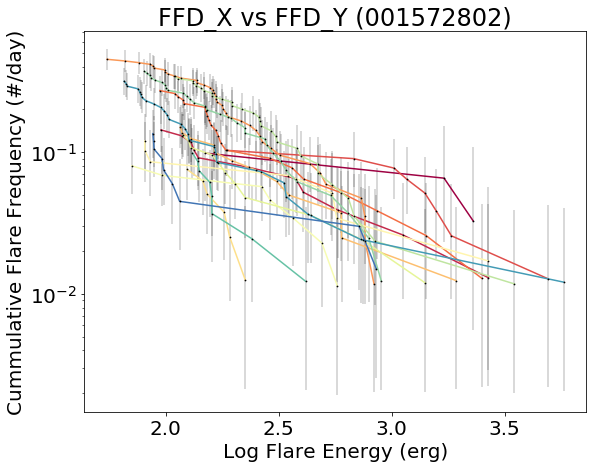

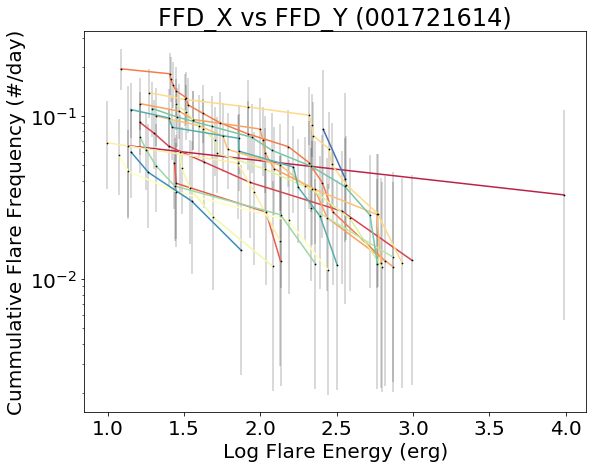

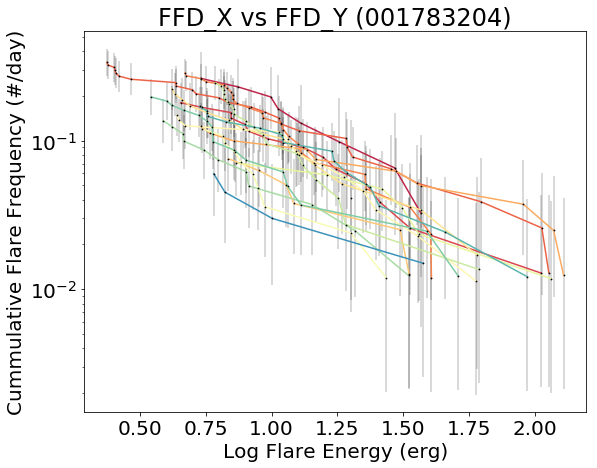

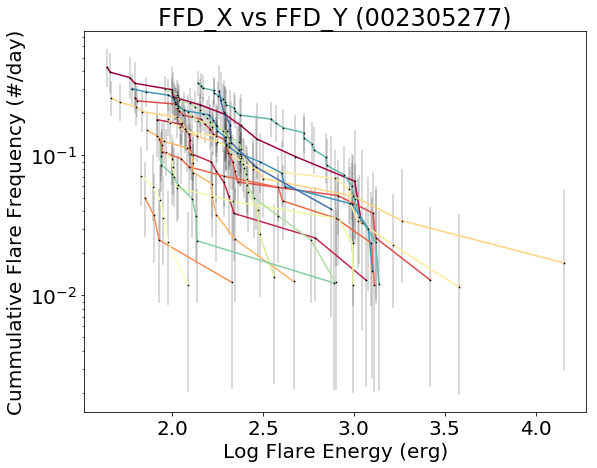

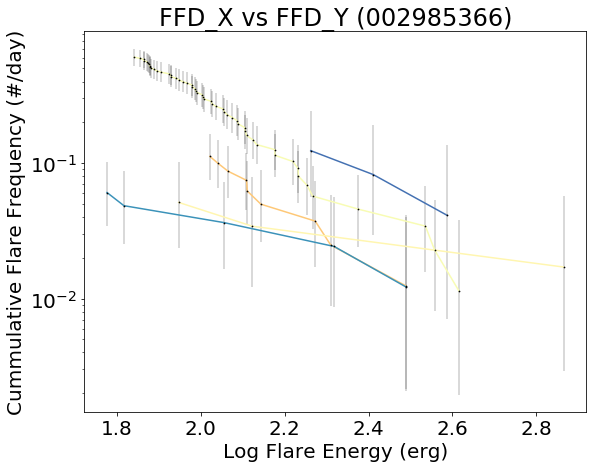

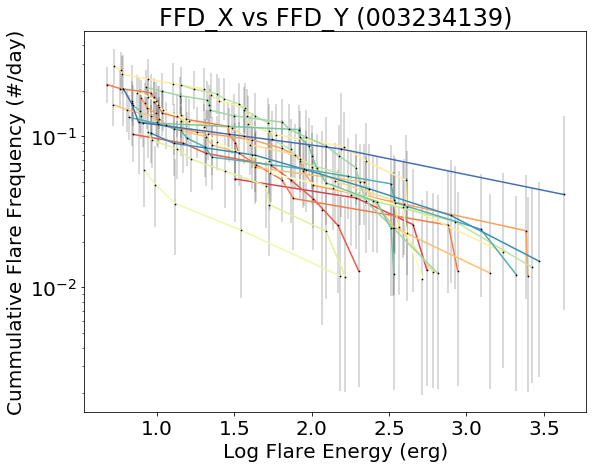

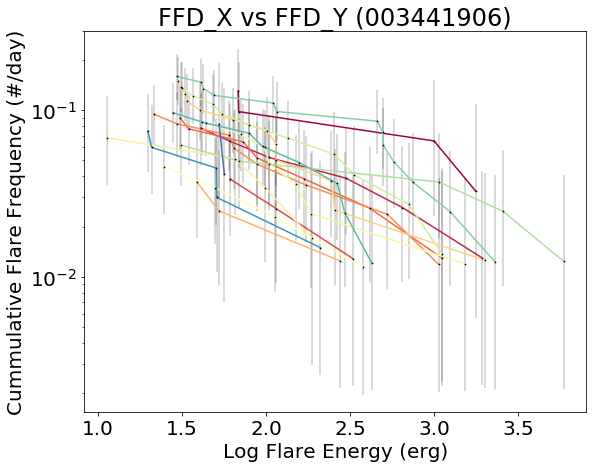

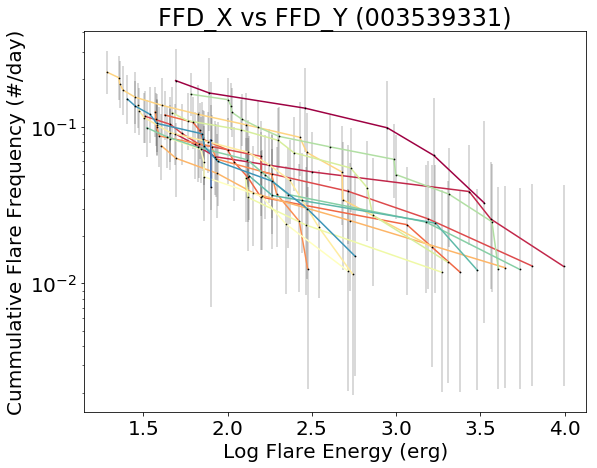

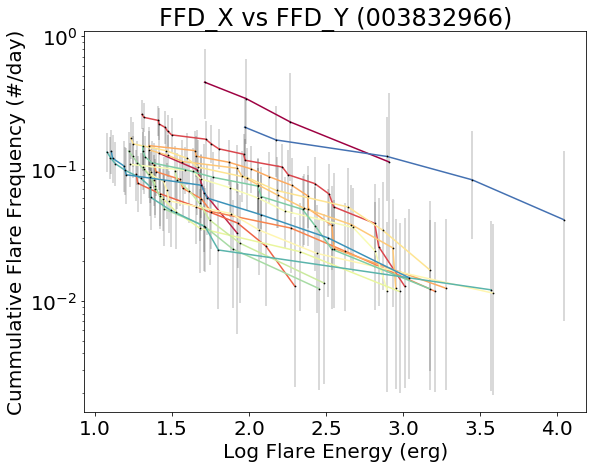

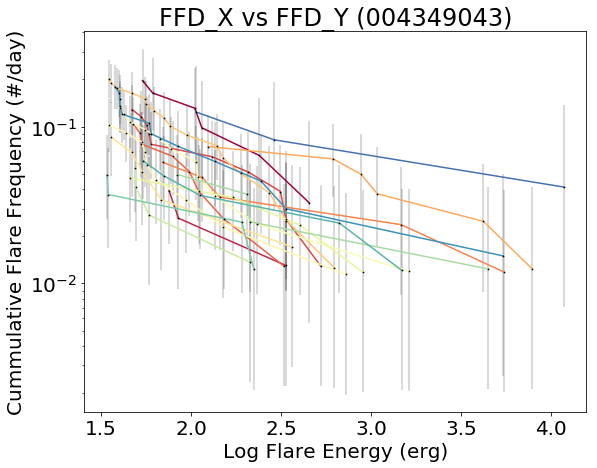

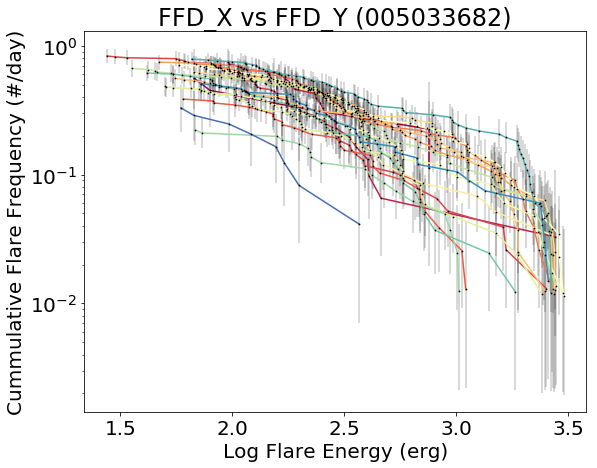

In [23]:
#plotting a reverse cummulative sum for a single KIC# number (using ED68i cutoff), hoping for a smooth change in frequency over time

targets = open("KICs/targets.txt", "r") # a file containing all the KICs we want to plot

for line in targets: #going through each KIC
    
    KIC = line.rstrip('\n') #stripping the return off each line
    files = glob('KICs/'+KIC+"/*.flare") #Glob all of the files in the directory - get all flares for a star
    
    plt.figure(figsize=(9,7))
    plt.title("FFD_X vs FFD_Y ("+KIC+')')
    plt.ylabel("Cummulative Flare Frequency (#/day)")
    plt.xlabel("Log Flare Energy (erg)")
    plt.yscale('log')
    energyList = []
    frequencyList = []
    
    for x in range(len(files)):
        
    
        #getting the total duration of each file
        toteDur = pd.read_table(files[x], skiprows=5, nrows=1, header=None, delim_whitespace=True, usecols=(7,)).iloc[0].values[0] 

                
        df = pd.read_table(files[x], comment="#", delimiter=",", names=names)
        energy = df['Equiv_Dur'] #This is the energy column of the flare data
        sort = np.argsort(energy) #get indices that would sort the energy array

        
        ffd_xEnergy = np.log10(energy[sort][::-1]) + EPOINT #log the reverse of sorted energy
        ffd_yFrequency = (np.arange(1, len(ffd_xEnergy)+1, 1))/toteDur #get evenly spaced intervals, divide by totedur to get flares/day

        ok68 = ffd_xEnergy >= np.log10(np.median(df['ED68i'])) + EPOINT #use ED68i to get indices of useful data, ignore the junk
    
        plt.plot(ffd_xEnergy[ok68], ffd_yFrequency[ok68], c = cmap(x/float(len(files)))) #only plotting significant data, using ok68

        
        err_dn =  []
        err_up = []
        
        for y in range (len(ffd_yFrequency[ok68])): #calculating the error bars for each point

            toteFlare = toteDur*ffd_yFrequency[ok68][y]
            err_dn.append((np.abs(toteFlare * (1.-1./(9. * toteFlare)-1./(3.*np.sqrt(toteFlare)))**3.-toteFlare))/toteDur)
            err_up.append((np.sqrt(toteFlare + 0.75) + 1.0)/toteDur)
           
        plt.errorbar(ffd_xEnergy[ok68], ffd_yFrequency[ok68], yerr = [err_dn, err_up], c = 'black', elinewidth=.3, fmt='o', markersize = .75)

        
    
    #plt.savefig('ffd_x-vs-ffd_y-sig-plot/'+KIC+'_sig_FFD.png')



In [ ]:
##to be used from terminal
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

#a bunch of checks, looking for correct input
if(len(sys.argv) == 1 or (sys.argv[1] == "help")):
    print("input: 'flaregraphs.py'   'KIC_number_targets.txt' 'evf'             for an energy vs frequency plot")
    print("input: 'flaregraphs.py'   'KIC_number_targets.txt' 'evfs'            for an energy vs frequency plot, plotting only the data above the ED68i cutoff")
    print("input: 'flaregraphs.py'   'KIC_number_targets.txt' 'tvf' 'energy#'   for a time vs frequency plot, fixed at the specified log-energy value")
    sys.exit()

try:
    file = sys.argv[1]
    targets = open(file, "r") # a file containing all the KICs we want to plot
except:
    print("Error: Cannot open "+file+". Type 'help' for a list of possible commands")
    sys.exit()

if((len(sys.argv) == 2) or (not((sys.argv[2] == "evfs") or (sys.argv[2] == "evf") or (sys.argv[2] == "tvf")))):
    print("Error: Unrecognized command. Type 'help' for a list of possible commands.")
    sys.exit()

    

np.seterr(invalid='ignore') #ignore the Nans
plt.rcParams.update({'font.size': 20}) #font size
cmap = plt.cm.Spectral # color scheme -- visible color spectrum, starting with red as the earliest
names=("t_start", "t_stop", "t_peak", "amplitude", "FWHM", "duration", "t_peak_aflare1",
       "t_FWHM_aflare1", "amplitude_aflare1", "flare_chisq", "KS_d_model", "KS_p_model",
       "KS_d_cont", "KS_p_cont", "Equiv_Dur", "ED68i", "ED90i")
EPOINT = 0


###################################################################################################################################
#plotting energy vs frequency
###################################################################################################################################
def plotEVF():

    for line in targets: #going through each KIC

        KIC = line.rstrip('\n') #stripping the return off each line
        files = glob('KICs/'+KIC+"/*.flare") #Glob all of the files in the directory - get all flares for a star

        plt.figure(figsize=(9,7))
        plt.title("FFD_X vs FFD_Y ("+KIC+')')
        plt.ylabel("Cummulative Flare Frequency (#/day)")
        plt.xlabel("Log Flare Energy (erg)")
        plt.yscale('log')

        for x in range(len(files)):

            #getting the total duration of each file
            toteDur = pd.read_table(files[x], skiprows=5, nrows=1, header=None, delim_whitespace=True, usecols=(7,)).iloc[0].values[0] 

            df = pd.read_table(files[x], comment="#", delimiter=",", names=names)
            energy = df['Equiv_Dur'] #This is the energy column of the flare data
            sort = np.argsort(energy) #get indices that would sort the energy array

            ffd_xEnergy = np.log10(energy[sort][::-1]) + EPOINT #log the reverse of sorted energy
            ffd_yFrequency = (np.arange(1, len(ffd_xEnergy)+1, 1))/toteDur #get evenly spaced intervals, divide by totedur to get flares/day

            ok68 = ffd_xEnergy >= np.log10(np.median(df['ED68i'])) + EPOINT #use ED68i to get indices of useful data, ignore the junk

            plt.plot(ffd_xEnergy[ok68], ffd_yFrequency[ok68], c = cmap(x/float(len(files)))) #only plotting significant data, using ok68
            plt.plot(ffd_xEnergy, ffd_yFrequency, lw = 0.3, c = cmap(x/float(len(files)))) #plotting all data


            #plotting the error bars. Must use the total flare #, rather than frequency, to calc the error.
            err_dn =  []
            err_up = []

            for y in range (len(ffd_yFrequency)):

                toteFlare = toteDur*ffd_yFrequency[y]
                err_dn.append((np.abs(toteFlare * (1.-1./(9. * toteFlare)-1./(3.*np.sqrt(toteFlare)))**3.-toteFlare))/toteDur)
                err_up.append((np.sqrt(toteFlare + 0.75) + 1.0)/toteDur)

            plt.errorbar(ffd_xEnergy, ffd_yFrequency, yerr = [err_dn, err_up], c = 'black', elinewidth=.3, fmt='o', markersize = .55)

        plt.savefig('ffd_x-vs-ffd_y-whole-plot/'+KIC+'_whole_FFD.png')
        
    plt.show()

###################################################################################################################################
#plotting energy vs frequency but only for significant data, data above the ED68i cutoff
###################################################################################################################################
def plotEVFsig():

    for line in targets: #going through each KIC

        KIC = line.rstrip('\n') #stripping the return off each line
        files = glob('KICs/'+KIC+"/*.flare") #Glob all of the files in the directory - get all flares for a star

        plt.figure(figsize=(9,7))
        plt.title("FFD_X vs FFD_Y ("+KIC+')')
        plt.ylabel("Cummulative Flare Frequency (#/day)")
        plt.xlabel("Log Flare Energy (erg)")
        plt.yscale('log')
        energyList = []
        frequencyList = []

        for x in range(len(files)):


            #getting the total duration of each file
            toteDur = pd.read_table(files[x], skiprows=5, nrows=1, header=None, delim_whitespace=True, usecols=(7,)).iloc[0].values[0] 


            df = pd.read_table(files[x], comment="#", delimiter=",", names=names)
            energy = df['Equiv_Dur'] #This is the energy column of the flare data
            sort = np.argsort(energy) #get indices that would sort the energy array


            ffd_xEnergy = np.log10(energy[sort][::-1]) + EPOINT #log the reverse of sorted energy
            ffd_yFrequency = (np.arange(1, len(ffd_xEnergy)+1, 1))/toteDur #get evenly spaced intervals, divide by totedur to get flares/day

            ok68 = ffd_xEnergy >= np.log10(np.median(df['ED68i'])) + EPOINT #use ED68i to get indices of useful data, ignore the junk

            plt.plot(ffd_xEnergy[ok68], ffd_yFrequency[ok68], c = cmap(x/float(len(files)))) #only plotting significant data, using ok68


            err_dn =  []
            err_up = []

            for y in range (len(ffd_yFrequency[ok68])): #calculating the error bars for each point

                toteFlare = toteDur*ffd_yFrequency[ok68][y]
                err_dn.append((np.abs(toteFlare * (1.-1./(9. * toteFlare)-1./(3.*np.sqrt(toteFlare)))**3.-toteFlare))/toteDur)
                err_up.append((np.sqrt(toteFlare + 0.75) + 1.0)/toteDur)

            plt.errorbar(ffd_xEnergy[ok68], ffd_yFrequency[ok68], yerr = [err_dn, err_up], c = 'black', elinewidth=.3, fmt='o', markersize = .75)
     
        plt.savefig('ffd_x-vs-ffd_y-sig-plot/'+KIC+'_sig_FFD.png')

    plt.show()

    
###################################################################################################################################
#Specify a fixed log-energy value. Plot the mean-time vs FFD_y values = plot time vs flare rate per day
###################################################################################################################################
def plotTVF(logEnergyConstant): 

    for line in targets: #going through each KIC

        KIC = line.rstrip('\n') #stripping the return off each line
        files = glob('KICS/'+KIC+"/*.flare") #Glob all of the files in the directory - get all flares for a star

        plt.figure(figsize=(9,7))
        plt.title("Time vs FFD_Y (KIC "+KIC+')')
        plt.ylabel("Cummulative Flare Frequency (#/day)")
        plt.xlabel("Mean T_Start (days)")
        plt.yscale('log')
        plt.ylim([0.001,10])
        plt.xlim([0,1800])
        time = []
        frequency = []
        err_list = []
        chisqSum = 0

        for x in range(len(files)):

            #getting the total duration of each file
            toteDur = pd.read_table(files[x], skiprows=5, nrows=1, header=None, delim_whitespace=True, usecols=(7,)).iloc[0].values[0] 


            df = pd.read_table(files[x], comment="#", delimiter=",", names=names)
            energy = df['Equiv_Dur'] #This is the energy column of the flare data
            sort = np.argsort(energy) #get indices that would sort the energy array


            ffd_xEnergy = np.log10(energy[sort][::-1]) + EPOINT #log the reverse of sorted energy
            ffd_yFrequency = (np.arange(1, len(ffd_xEnergy)+1, 1))/toteDur #get evenly spaced intervals, divide by totedur to get flares/day


            if(np.amax(ffd_xEnergy) >= logEnergyConstant >= np.amin(ffd_xEnergy)): #checking that the energy constant isn't out of bound,
                                                                                   #otherwise, interpolate doesn't work

                ok68 = ffd_xEnergy >= np.log10(np.median(df['ED68i'])) + EPOINT #use ED68i to get indices of useful data, ignore the junk

                meanstart = np.sum(df['t_start'])/len(df['t_start']) #finding the mean time for a file


                if any(ok68): #checking if ok68 contains at least one 'true'


                    ffd_yForMeanstart = np.interp(logEnergyConstant, ffd_xEnergy[ok68][::-1], ffd_yFrequency[ok68][::-1])#interpolating the ffd_y

                    time.append(meanstart) #making lists so we can fit a line later
                    frequency.append(ffd_yForMeanstart)


                    toteFlare = ffd_yForMeanstart * toteDur #calculating error bars: multiplying the frequency by total duration to get total flare #   


                    err_dn = (np.abs(toteFlare * (1.-1./(9. * toteFlare)-1./(3.*np.sqrt(toteFlare)))**3.-toteFlare))/toteDur
                    err_up = (np.sqrt(toteFlare + 0.75) + 1.0)/toteDur
                    err_list.append(err_up) #collecting errors, to be used in chi-square calc


                    plt.errorbar(meanstart, ffd_yForMeanstart, yerr = [[err_dn], [err_up]], fmt='ro',markersize=6, elinewidth=1,capsize=6)#plotting error


        #return the parameters (slope and intercept) and the covariance matrix. Plot a line with those parameters                        
        params, cov = np.polyfit(time, frequency, 1, cov=True, full =False)
        slope, intercept = params
        line_y = [slope * i + intercept for i in time]
        plt.plot(time, line_y, 'black',  lw=3,) #plotting a best fit line


        #chi-square calculation
        for y in range(len(frequency)):
            chisqSum += ((frequency[y] - line_y[y]) / err_list[y])**2.0 
        chisq = chisqSum / np.size(frequency)


        #adding vales to graph, using the convariance matrix to get error in the slope
        plt.text(50, 6,'Slope = {:0.2e} +/- {:0.2e}'.format(slope,np.sqrt(cov[0][0])))
        plt.text(50, 3.5,'Slope/Uncertainty = {:0.2f}'.format(np.abs(slope/np.sqrt(cov[0][0]))))
        plt.text(50, 2,'Chi-Square = {:0.2f}'.format(chisq))

        #plt.savefig('time-vs-ffd_y-plot/'+KIC+'_vs_time(E=' + str(logEnergyConstant) + ').png')
        
    plt.show()
    
###################################################################################################################################
###################################################################################################################################

if(sys.argv[2] == "evf"): #plotting energy vs frequency
    plotEVF()

elif(sys.argv[2] == "evfs"): #plotting significant energy vs frequency
    plotEVFsig()

elif(sys.argv[2] == "tvf"): #plotting time vs frequency
    try:
        logEnergyConstant = float(sys.argv[3]) + EPOINT # the fixed energy value
    except:
        print("Error: Cannot convert fixed-energy value to a float OR no fixed-energy value was provided . Type 'help' for a list of possible commands.")
        sys.exit()
    plotTVF(logEnergyConstant)
